In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [90]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


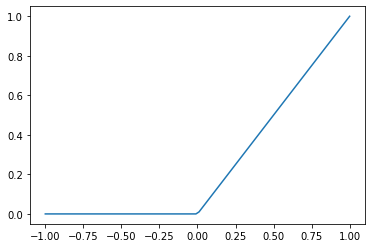

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

In [7]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

# Random volumes - voxel

In [149]:
from typing import *

from abc import abstractmethod, ABCMeta

class AbsPassiveGenerator(metaclass=ABCMeta):
    def __init__(self, materials:Optional[List[str]]=None) -> None:
        if materials is None: materials = [m for m in X0]
        self.materials = materials
    
    @abstractmethod
    def generate(self) -> Callable[..., Tensor]:
        pass
    
    
class VoxelPassiveGenerator(AbsPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        def generator(*, z:float, lw:Tensor, size:float) -> Tensor:
            x0s = lw.new_tensor([X0[m] for m in self.materials])
            shp = (lw/size).long()
            return x0s[torch.randint(high=len(x0s), size=(shp.prod(),), device=x0s.device)].reshape(list(shp))
        return generator

In [150]:
vpg = VoxelPassiveGenerator()

In [151]:
vpg.generate()(z=0.1,size=0.1,lw=volume.lw)

tensor([[0.0176, 0.0890, 0.0937, 0.0176, 0.0056, 0.1932, 0.0937, 0.0144, 0.0937,
         0.0890],
        [0.0144, 0.0890, 0.1932, 0.0056, 0.0176, 0.1932, 0.0176, 0.3528, 0.1932,
         0.0176],
        [0.3528, 0.0176, 0.0890, 0.0144, 0.0890, 0.0144, 0.0144, 0.0176, 0.0056,
         0.0056],
        [0.0937, 0.0176, 0.0144, 0.1932, 0.0144, 0.3528, 0.3528, 0.0056, 0.0890,
         0.0056],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.0144, 0.1932, 0.0056, 0.0056, 0.3528,
         0.3528],
        [0.0937, 0.3528, 0.0937, 0.0176, 0.0056, 0.0176, 0.3528, 0.1932, 0.0890,
         0.0176],
        [0.1932, 0.0890, 0.0176, 0.0176, 0.0937, 0.0176, 0.0056, 0.0056, 0.1932,
         0.3528],
        [0.0144, 0.1932, 0.0056, 0.0176, 0.0056, 0.0056, 0.0890, 0.0144, 0.0144,
         0.0176],
        [0.0890, 0.0144, 0.1932, 0.0176, 0.0056, 0.0144, 0.0056, 0.0144, 0.0056,
         0.3528],
        [0.0144, 0.0937, 0.0144, 0.0176, 0.0890, 0.3528, 0.0890, 0.0890, 0.0144,
         0.0937]])

In [152]:
class PassiveYielder:
    def __init__(self, passives: Union[List[Callable[..., Tensor]], AbsPassiveGenerator], n_passives: Optional[int] = None, shuffle: bool = True):
        self.passives, self.n_passives, self.shuffle = passives, n_passives, shuffle
        if isinstance(self.passives, AbsPassiveGenerator):
            if self.n_passives is None:
                raise ValueError("If a AbsPassiveGenerator class is used, n_passives must be specified")
        else:
            self.n_passives = len(self.passives)

    def __len__(self) -> int:
        return self.n_passives

    def __iter__(self) -> Generator[Callable[..., Tensor], None, None]:
        if isinstance(self.passives, AbsPassiveGenerator):
            for _ in range(self.n_passives):
                yield self.passives.generate()
        else:
            if self.shuffle:
                shuffle(self.passives)
            for p in self.passives:
                yield p

In [153]:
py = PassiveYielder(vpg, n_passives=2)

In [154]:
for i,p in enumerate(py): print(i,p(z=0.1,size=0.1,lw=volume.lw))

0 tensor([[0.0144, 0.0176, 0.0056, 0.1932, 0.0056, 0.0056, 0.0144, 0.0937, 0.0144,
         0.0176],
        [0.0176, 0.0937, 0.0144, 0.0937, 0.0176, 0.0144, 0.0890, 0.0056, 0.0056,
         0.1932],
        [0.1932, 0.0890, 0.0937, 0.0144, 0.0176, 0.3528, 0.0937, 0.0176, 0.0056,
         0.1932],
        [0.3528, 0.0176, 0.3528, 0.0937, 0.0176, 0.0176, 0.0937, 0.3528, 0.1932,
         0.0890],
        [0.0937, 0.0890, 0.0176, 0.1932, 0.3528, 0.1932, 0.0176, 0.0176, 0.0890,
         0.0937],
        [0.0144, 0.0056, 0.0144, 0.0937, 0.0937, 0.0176, 0.0937, 0.0890, 0.0056,
         0.1932],
        [0.0144, 0.0937, 0.0890, 0.3528, 0.0176, 0.3528, 0.0144, 0.0056, 0.0890,
         0.0890],
        [0.0144, 0.0937, 0.0144, 0.0937, 0.3528, 0.1932, 0.0144, 0.0937, 0.0144,
         0.1932],
        [0.3528, 0.0056, 0.0890, 0.0144, 0.0144, 0.0056, 0.0144, 0.0056, 0.0056,
         0.0176],
        [0.0176, 0.0144, 0.0937, 0.0176, 0.0056, 0.1932, 0.0890, 0.0056, 0.0056,
         0.0144]])
1 tenso

In [87]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=DetectorLoss(target_budget=4, cost_coef=None))  # Loss is precision + budget_coef*cost_coef, balance coef as required or leave as None to automatically balance on first batch

In [88]:
preds = wrapper.predict(PassiveYielder(vpg, n_passives=1),
                        n_mu_per_volume=1000,
                        mu_bs=100)

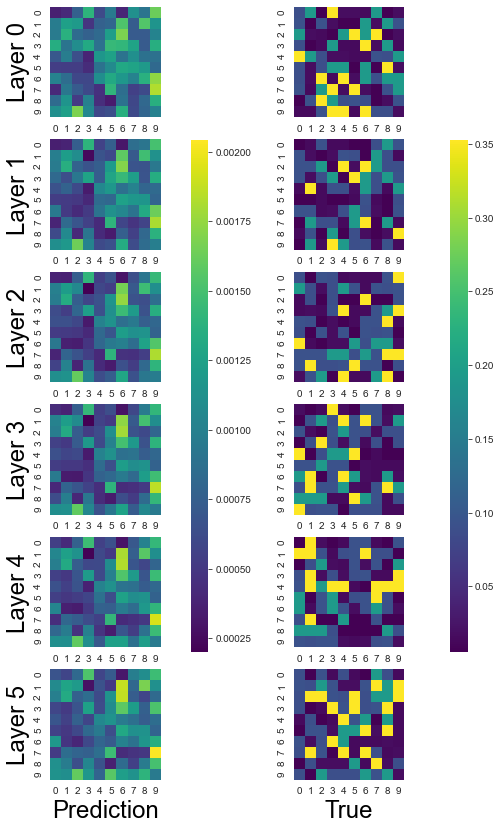

In [91]:
plot_pred_true_x0(*preds[0])

# Block

In [216]:
class BlockPassiveGenerator(AbsPassiveGenerator):
    def __init__(self, lw:Tuple[float,float], z_range:Tuple[float,float], block_size:Tuple[float,float,float], sort_x0:bool, materials:Optional[List[str]]=None) -> None:
        super().__init__(materials=materials)
        self.lw,self.z_range,self.block_size,self.sort_x0 = lw,z_range,block_size,sort_x0
    
    def generate(self) -> Callable[..., Tensor]:
        mats = np.random.choice(self.materials, 2, replace=False)
        base_x0 = X0[mats[0]]
        block_x0 = X0[mats[1]]
        if self.sort_x0 and base_x0 < block_x0:  # Ensure block is denser material
            base_x0,block_x0 = block_x0,base_x0
            
        block_size = np.random.choice(self.block_size, 3, replace=False)
        block_centre = np.hstack((np.random.uniform(high=self.lw[0]),np.random.uniform(high=self.lw[1]),np.random.uniform(*self.z_range)))
        
        block_low = block_centre - (block_size/2)
        block_high = block_centre + (block_size/2)
        
        def generator(*, z:float, lw:Tensor, size:float) -> Tensor:
            shp = (lw/size).long()
            low_xy = np.round(block_low[:2]/size).astype(int)
            high_xy = np.round(block_high[:2]/size).astype(int)
            rad_length = torch.ones(list(shp))*base_x0
            if z >= block_low[2] and z <= block_high[2]:
                rad_length[low_xy[0]:high_xy[0],low_xy[1]:high_xy[1]] = block_x0
            return rad_length
        
        return generator

In [222]:
bpg = BlockPassiveGenerator(lw=[1.,1.], z_range=[0.2,0.8], block_size=[0.4,0.4,0.2], sort_x0=False)

In [223]:
p = bpg.generate()

In [224]:
p(z=0.7,size=0.1,lw=volume.lw)

tensor([[0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.1932,
         0.1932],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.1932,
         0.1932],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528],
        [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
         0.3528]])

In [225]:
preds = wrapper.predict(PassiveYielder(bpg, n_passives=5),
                        n_mu_per_volume=100,
                        mu_bs=100)

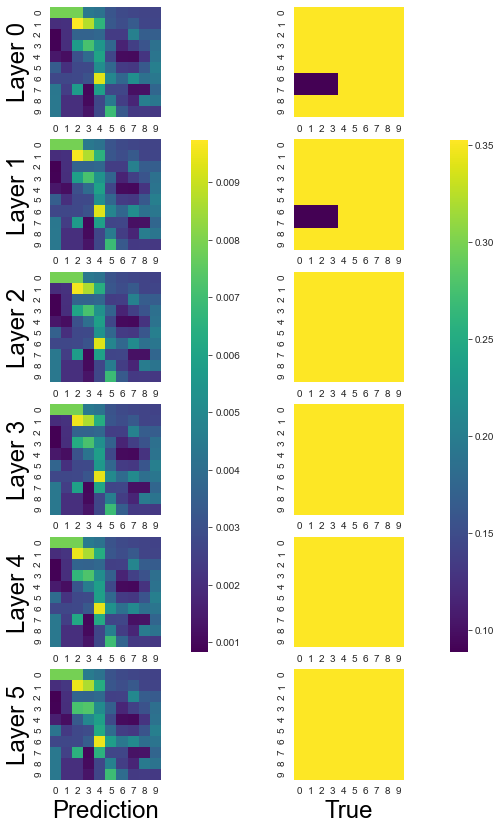

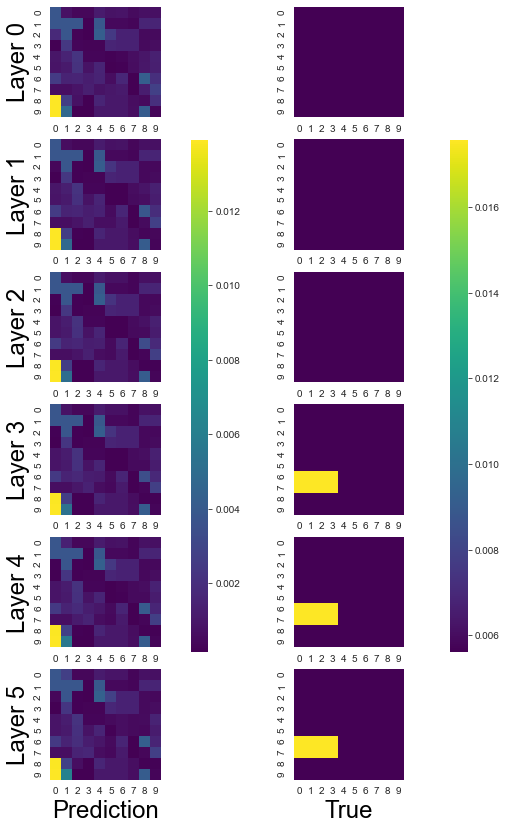

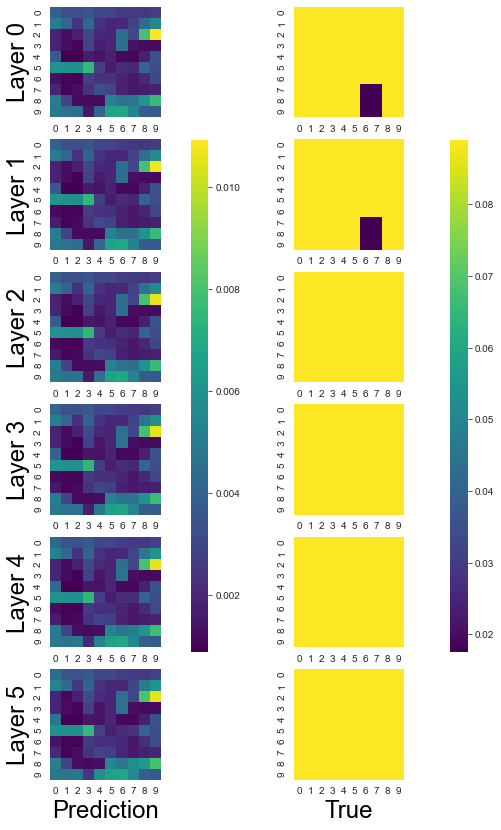

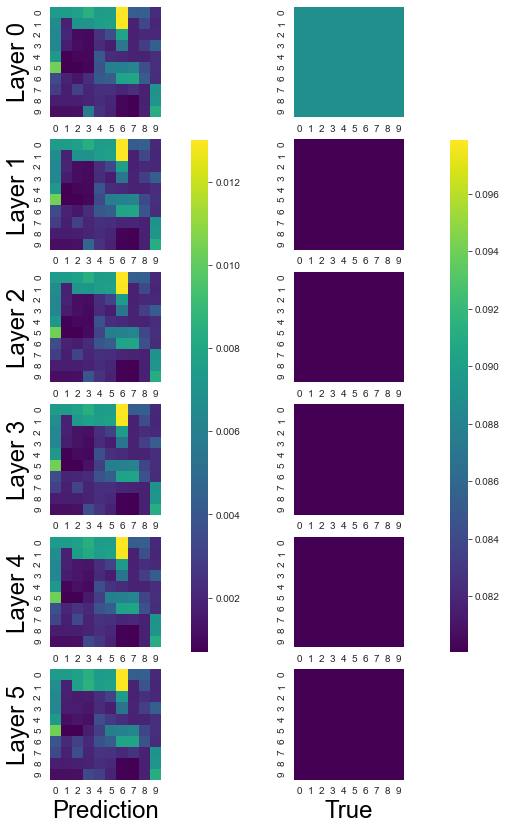

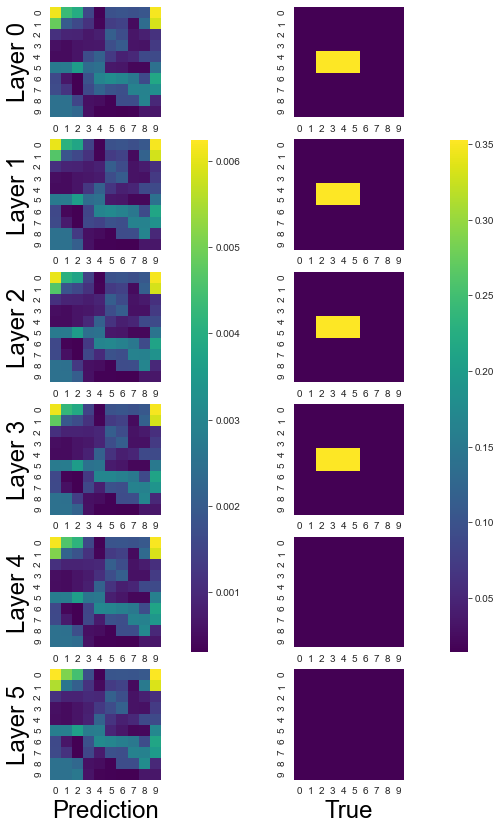

In [226]:
for p in preds: plot_pred_true_x0(*p)